In [12]:
#https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7


#  Scale-Fit Only Test Data

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math


In [14]:
ab_path='../data/SET50-Daily-Y09-Now.csv'
start_date='2016-01-01'
end_date='2022-12-31'

split_by=1  # 1= percent 2=date
train_ratio=0.8  
test_date='2021-08-01'

way=1

prediction_col='Price'

#my_features=['Price']
my_features=['Price','EMA1','EMA2']
# my_features=['Price', 'EMA1', 'MACD', 'RSI']
#my_features=['Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']

# prediction_col='MACD'
# my_features=['MACD', 'SIGNAL','RSI-MA']

hops_lookback=22

epochs = 100
batch_size = 32
n_early=0


In [15]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
print(list(df.columns))
df.rename(columns={'Date/Time':'Date'},inplace=True)
df.set_index('Date',inplace=True)


['Ticker', 'Date/Time', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [16]:
df=df[my_features]
df=df[start_date:end_date]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2016-01-04 00:00:00 to 2022-12-16 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1692 non-null   float64
 1   EMA1    1692 non-null   float64
 2   EMA2    1692 non-null   float64
dtypes: float64(3)
memory usage: 52.9 KB
None


In [17]:
print(df.shape)
if  split_by==1:
    print("Split by train ratio") 
    train_data_length = math.ceil(len(df) * train_ratio)
    print(f"Split the data into train({train_ratio})={train_data_length} and the remaining  is test")  
    df_train=df.iloc[0:train_data_length,:]
    df_test=df.iloc[train_data_length:,:]

else:
    print("Split by test date")  
    df_train=df[:test_date]
    df_test=df[test_date:]


print(df_train.shape, df_train[-3:])
print(df_test.shape,df_test[-3:])

df.reset_index(inplace=True)
dfDate=df[['Date']]
print("=========================================")
print("Split data summary")
print(f"{dfDate['Date'].min()} - {dfDate['Date'].max()}") 
print(f'Train/All Ratio = { round( (len(df_train)/len(df)),2)}')

(1692, 3)
Split by train ratio
Split the data into train(0.8)=1354 and the remaining  is test
(1354, 3)              Price    EMA1    EMA2
Date                              
2021-07-20  920.40  937.28  944.41
2021-07-21  922.25  934.55  942.30
2021-07-22  929.30  933.60  941.06
(338, 3)              Price    EMA1    EMA2
Date                              
2022-12-14  984.70  983.16  983.51
2022-12-15  978.58  982.33  983.04
2022-12-16  980.24  981.95  982.77
Split data summary
2016-01-04 00:00:00 - 2022-12-16 00:00:00
Train/All Ratio = 0.8


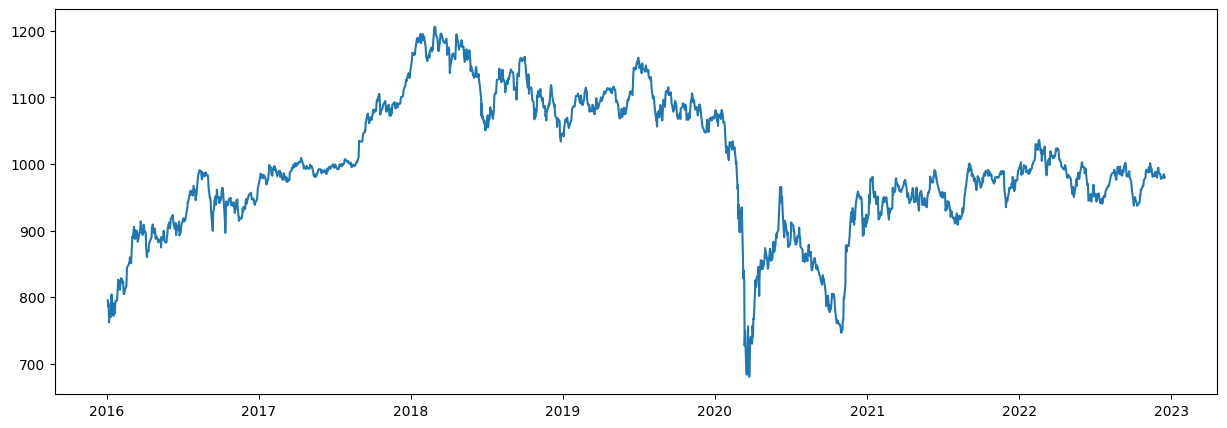

In [18]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df[prediction_col])
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
 ##scaler_x = StandardScaler ()
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html 
def scale_x(dfX,colY):
 scalerX= MinMaxScaler(feature_range=(0, 1))
 X_scaled=scalerX.fit_transform(dfX)
 print(X_scaled.shape)
    
 scalerY= MinMaxScaler(feature_range=(0, 1))  
 y_scaled=scalerY.fit_transform(dfX[[colY]])
 print(y_scaled.shape)   
    
 return X_scaled,y_scaled ,scalerX,  scalerY
print("Max-Min Scalar only Train")
XTrain_scaled,yTrain_scaled,scX,scY=scale_x(df_train,prediction_col)


print(XTrain_scaled[:3])
print(XTrain_scaled[-3:])

Max-Min Scalar only Train
(1354, 3)
(1354, 1)
[[0.21830344 0.17640486 0.13540839]
 [0.20076391 0.1655603  0.12616451]
 [0.20893509 0.15839632 0.1187983 ]]
[[0.45669276 0.44878957 0.42042801]
 [0.46020827 0.44280863 0.41534869]
 [0.4736052  0.44072735 0.41236369]]


In [20]:
total_len=XTrain_scaled.shape[0]

X_train=[]
y_train=[]

for i in range(hops_lookback,total_len):
   X_train.append(XTrain_scaled[i-hops_lookback:i]) 
   y_train.append(yTrain_scaled[i][0])
    
X_train=np.array(X_train)
y_train=np.array(y_train)


print(X_train.shape)
print(y_train.shape)

#https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

(1332, 22, 3)
(1332,)


In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Flatten,Dropout
import tensorflow as tf

In [22]:
n_input_lookback=X_train.shape[1]  # n_input=hops it is how far back in time do you want to use for training on time series model.
n_feature=X_train.shape[2]  # univariate is always 1  but multivariaate are n features
print(f'n_put lookback :{n_input_lookback}')
print(f'n_feature :{n_feature}')


#lstm_neuron_number=50
lstm_neuron_number = n_input_lookback * n_feature  #n_features=1
print(f"{lstm_neuron_number}= {n_input_lookback} x {n_feature} (univariate n_features=1)")

callback = EarlyStopping(monitor='loss', patience=2)

n_put lookback :22
n_feature :3
66= 22 x 3 (univariate n_features=1)


In [23]:
tf.random.set_seed(7)

model=Sequential()


if way==1:
 model.add(LSTM(units=lstm_neuron_number, return_sequences=False, input_shape=(n_input_lookback,n_feature )))
elif way==2:
 model.add(LSTM(units=lstm_neuron_number, return_sequences=True, input_shape=(n_input_lookback,n_feature )))
 model.add(LSTM(units=lstm_neuron_number, return_sequences=False))
else :
    model.add(LSTM(units=lstm_neuron_number, return_sequences=True, input_shape=(n_input_lookback,n_feature )))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_neuron_number)) #layer2  additonal
    model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


Way=1
Epoch 1/100
42/42 - 7s - loss: 0.0238 - 7s/epoch - 168ms/step
Epoch 2/100
42/42 - 1s - loss: 0.0037 - 953ms/epoch - 23ms/step
Epoch 3/100
42/42 - 1s - loss: 0.0036 - 1s/epoch - 27ms/step
Epoch 4/100
42/42 - 1s - loss: 0.0035 - 1s/epoch - 27ms/step
Epoch 5/100
42/42 - 1s - loss: 0.0033 - 1s/epoch - 25ms/step
Epoch 6/100
42/42 - 1s - loss: 0.0031 - 1s/epoch - 29ms/step
Epoch 7/100
42/42 - 1s - loss: 0.0030 - 1s/epoch - 28ms/step
Epoch 8/100
42/42 - 1s - loss: 0.0028 - 1s/epoch - 26ms/step
Epoch 9/100
42/42 - 1s - loss: 0.0027 - 1s/epoch - 26ms/step
Epoch 10/100
42/42 - 1s - loss: 0.0025 - 1s/epoch - 27ms/step
Epoch 11/100
42/42 - 1s - loss: 0.0024 - 1s/epoch - 31ms/step
Epoch 12/100
42/42 - 1s - loss: 0.0023 - 1s/epoch - 28ms/step
Epoch 13/100
42/42 - 1s - loss: 0.0022 - 1s/epoch - 25ms/step
Epoch 14/100
42/42 - 1s - loss: 0.0021 - 985ms/epoch - 23ms/step
Epoch 15/100
42/42 - 1s - loss: 0.0020 - 1s/epoch - 24ms/step
Epoch 16/100
42/42 - 1s - loss: 0.0019 - 962ms/epoch - 23ms/step
E

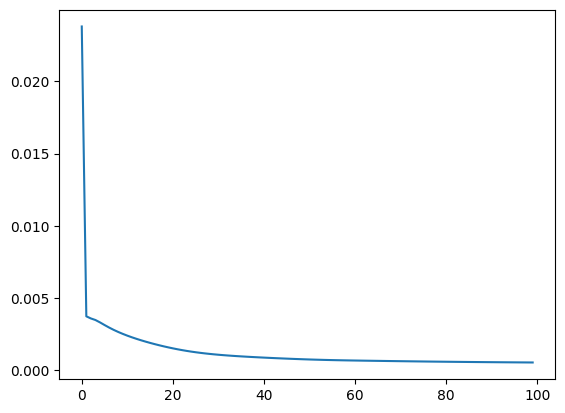

In [24]:
print(f"Way={way}")
if n_early>0:
 callback = EarlyStopping(monitor='loss', patience=n_early)
 model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size, shuffle=False,verbose=2,callbacks=[callback])
else:
 model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size, shuffle=False,verbose=2)

# plot history
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
df_tain_lastNhop=df_train.iloc[-n_input_lookback:]

df_full=pd.concat((df_tain_lastNhop,df_test),axis=0)
print('Test; ',df_test.shape)
print(f'All Test including {n_input_lookback} to predict the first test : ',df_full.shape)

Test;  (338, 3)
All Test including 22 to predict the first test :  (360, 3)


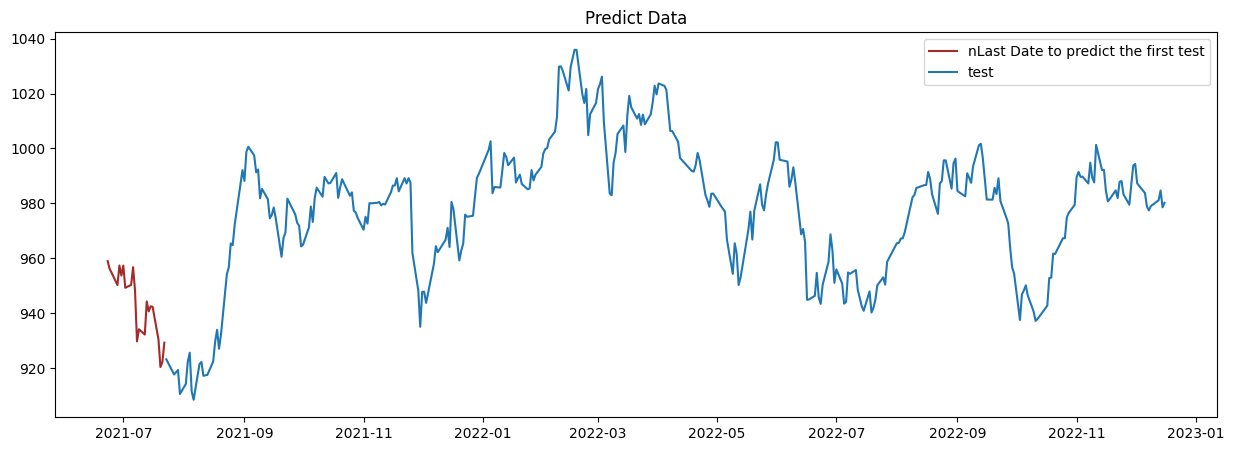

In [26]:
plt.figure(figsize=(15,5))
plt.plot(df_tain_lastNhop[prediction_col],color='Brown',label='nLast Date to predict the first test')
plt.plot(df_test[prediction_col],label='test')
plt.title('Predict Data')
plt.legend()
plt.show()

In [27]:
df_full_scaled=scX.transform(df_full)
df_full_scaled[:5]

no_full_test=len(df_full_scaled)
print(no_full_test)

360


In [28]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(hops_lookback,no_full_test):
   X_test.append(df_full_scaled[i-hops_lookback:i]) 

X_test=np.array(X_test)
print(X_test.shape)
# print(X_test[:2])

(338, 22, 3)


In [29]:
y_test_scaled_pred=model.predict(X_test)
y_test_pred=scY.inverse_transform(y_test_scaled_pred)
y_test_pred[:5]

11/11 [==============================] - 1s 9ms/step


array([[920.6736 ],
       [920.16315],
       [915.3802 ],
       [914.07904],
       [908.0724 ]], dtype=float32)

In [30]:
pred_col_result=f'Predict-{prediction_col}'
test_pred_df=pd.DataFrame(y_test_pred,columns=[pred_col_result])
print(test_pred_df.info())
test_pred_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Predict-Price  338 non-null    float32
dtypes: float32(1)
memory usage: 1.4 KB
None


,Predict-Price
333,969.781189
334,971.045959
335,973.723938
336,977.324646
337,973.836487


In [31]:
df_test=df_test.reset_index()
dfABC=pd.concat([df_test,test_pred_df],axis=1)
dfABC=dfABC.set_index('Date')
dfABC.tail()

,Price,EMA1,EMA2,Predict-Price
Date,,,,
2022-12-09,979.01,983.19,983.62,969.781189
2022-12-13,981.17,982.82,983.38,971.045959
2022-12-14,984.70,983.16,983.51,973.723938
2022-12-15,978.58,982.33,983.04,977.324646
2022-12-16,980.24,981.95,982.77,973.836487


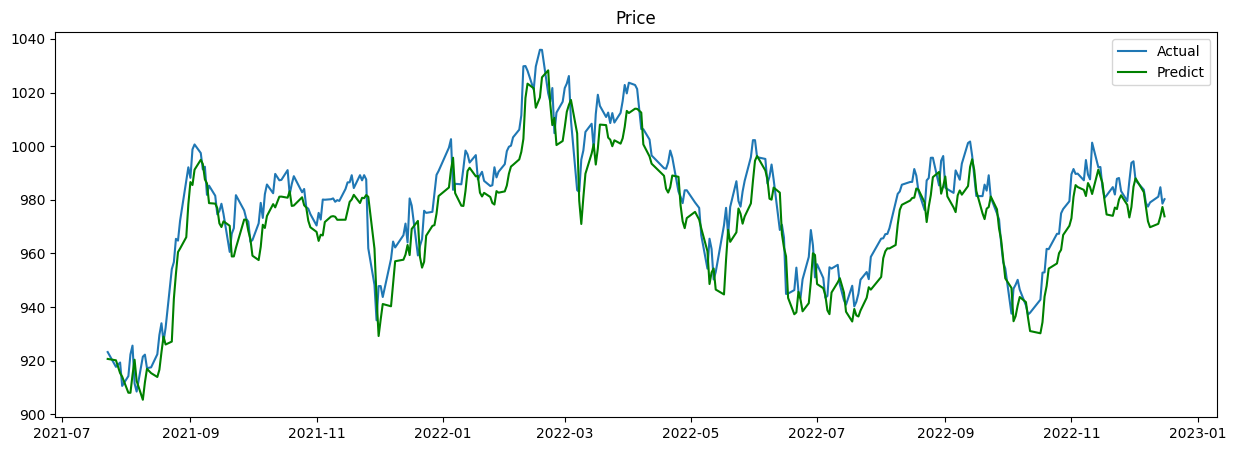

In [32]:
plt.figure(figsize=(15,5))
plt.plot(dfABC[prediction_col],label='Actual')
plt.plot(dfABC[pred_col_result],color='green',label='Predict')
plt.title(prediction_col)
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

rmse = np.sqrt(mean_squared_error(dfABC[prediction_col],dfABC[pred_col_result]))
print('Root Mean Square Error(RMSE): %.3f' % rmse)

mae=mean_absolute_error(dfABC[prediction_col], dfABC[pred_col_result])
print('Mean Absolute Error (MAE): ' + str(np.round(mae, 2)))

Root Mean Square Error(RMSE): 10.038
Mean Absolute Error (MAE): 8.45
